In [1]:
import json
import time

import numpy as np
import seaborn as sn
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(0)

def classify_subcategory(text):
    likelihoods = [0 for _ in range(len(SUBCATEGORIES))]
    text = set(removePunctuation(text).lower().split())
    for token in text:
        if token in stop_words:
            continue

        if token in word_to_subcat:
            for i in range(len(SUBCATEGORIES)):
                likelihoods[i] += word_to_subcat[token][i]
        else:
            # print('Token not in word-to-subcat:', token)
            pass

    return SUBCATEGORIES[likelihoods.index(max(likelihoods))]


def hhi(arr):
    return sum([_**2 for _ in arr]) / sum(arr) ** 2


def normalized_hhi(arr):
    return (hhi(arr) - 1/len(arr)) / (1 - 1/len(arr))


def removePunctuation(s, punctuation='''.,!-;:'"\/?@#$%^&*_~()[]{}“”‘’'''):
    return ''.join(ch for ch in s if ch not in punctuation)


with open('../stop-words.txt') as f:
    stop_words = set(f.readlines())
    stop_words = set([word.strip() for word in stop_words])

with open('../subcategories.txt') as f:
    SUBCATEGORIES = [line.strip() for line in f.readlines()]

time_now = time.perf_counter()
with open('word-to-subcat-normalized.json') as f:
    word_to_subcat = json.load(f)
print('Time to load word-to-subcat-normalized:', time.perf_counter() - time_now, 'seconds')

for word in word_to_subcat:
    if normalized_hhi(word_to_subcat[word]) < 0.01:
        print(word)
    # factor = normalized_hhi(word_to_subcat[word])
    factor = normalized_hhi(
        word_to_subcat[word])**5 / sum(word_to_subcat[word])
    word_to_subcat[word] = [factor * i for i in word_to_subcat[word]]


print('=====Begin Testing=====')
time_now = time.perf_counter()

questions = open('questions.json')
questions = questions.readlines()
np.random.shuffle(questions)
questions = questions[:int(0.2*len(questions))]
counter = 0
correct = 0
confusion_matrix = [[0 for _ in range(len(SUBCATEGORIES))]
                    for _ in range(len(SUBCATEGORIES))]
for line in questions:
    data = json.loads(line)
    if 'subcategory' not in data:
        continue

    counter += 1
    subcategory = data['subcategory']
    if subcategory not in SUBCATEGORIES:
        continue

    if data['type'] == 'tossup':
        prediction = classify_subcategory(data['question'])
    if data['type'] == 'bonus' and 'parts' in data and len(data['parts']) == 3:
        prediction = classify_subcategory(
            data['leadin'] + ' ' + data['parts'][0] + data['parts'][1] + data['parts'][2])

    subcategory_index = SUBCATEGORIES.index(subcategory)
    prediction_index = SUBCATEGORIES.index(prediction)

    confusion_matrix[subcategory_index][prediction_index] += 1

    if subcategory == prediction:
        correct += 1

    if counter % 10000 == 0:
        print(f'{correct}/{counter}')

print('=====End Testing=====')
print(f'Accuracy: {correct / counter} ({correct}/{counter})')
print('Time:', time.perf_counter() - time_now, 'seconds')


Time to load word-to-subcat-normalized: 2.8219396739732474 seconds
=====Begin Testing=====
7101/10000
14195/20000
21347/30000
=====End Testing=====
Accuracy: 0.7131852921706686 (23702/33234)
Time: 11.090133456047624 seconds


In [2]:
print('Confusion Matrix:')
for subcat, row in zip(SUBCATEGORIES, confusion_matrix):
    print(f'{subcat:20}', row)

Confusion Matrix:
American Literature  [1188, 87, 0, 53, 55, 10, 53, 2, 31, 15, 1, 17, 9, 6, 2, 18, 43, 44, 18, 17, 29, 21, 17, 3, 13, 3, 22]
British Literature   [60, 1115, 0, 35, 23, 7, 19, 4, 29, 14, 0, 15, 4, 4, 1, 8, 42, 49, 10, 18, 28, 20, 2, 1, 12, 4, 4]
Classical Literature [4, 8, 27, 3, 10, 2, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 4, 1, 2, 33, 8, 1, 0, 0, 0, 1]
European Literature  [41, 57, 1, 839, 28, 7, 11, 2, 33, 10, 1, 9, 3, 6, 0, 6, 34, 45, 10, 8, 23, 22, 3, 0, 9, 4, 4]
World Literature     [49, 38, 3, 39, 671, 10, 12, 3, 12, 33, 3, 10, 4, 7, 0, 3, 21, 15, 6, 17, 22, 10, 8, 2, 4, 2, 1]
Other Literature     [53, 49, 3, 19, 26, 21, 5, 0, 3, 6, 0, 4, 2, 3, 2, 2, 11, 19, 5, 2, 14, 7, 4, 1, 2, 1, 2]
American History     [34, 15, 1, 8, 14, 2, 1381, 3, 82, 71, 3, 27, 10, 15, 1, 8, 32, 19, 18, 24, 8, 23, 26, 15, 27, 5, 13]
Ancient History      [7, 5, 2, 4, 2, 1, 7, 284, 65, 31, 11, 7, 2, 2, 0, 1, 13, 10, 4, 9, 25, 11, 3, 1, 9, 1, 1]
European History     [18, 24, 0, 24, 3, 1, 70, 41, 1

<AxesSubplot:>

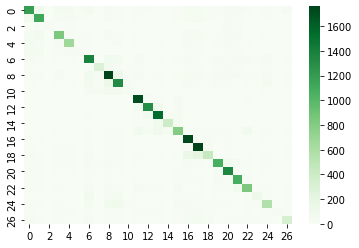

In [3]:
sn.heatmap(confusion_matrix, cmap='Greens', annot=False)

In [4]:
# ConfusionMatrixDisplay(np.array(confusion_matrix), display_labels='').plot()